## QA over unstructured data

Using Match LSTM, Pointer Networks, as mentioned in paper https://arxiv.org/pdf/1608.07905.pdf

We start with the pre-processing provided by https://github.com/MurtyShikhar/Question-Answering to clean up the data and make neat para, ques files.


### @TODOs:

1. [done] _Figure out how to put in real, pre-trained embeddings in embeddings layer._
2. [done] _Explicitly provide batch size when instantiating model_
3. is ./val.ids.* validation set or test set?: **validation**
4. [done:em] emInstead of test loss, calculate test acc metrics
    1. todo: new metrics like P, R, F1
5. Update unit test codes

In [1]:
# # Codeblock to pull up embeddings. Needs to run before following imports
# import numpy as np

# # Macros 
# DATA_LOC = './data/squad/'
# EMBEDDING_FILE = 'glove.trimmed.300.npz'
# VOCAB_FILE = 'vocab.dat'

# file_loc = DATA_LOC + EMBEDDING_FILE
# glove_file = np.load(open(file_loc))['glove']

In [2]:
from __future__ import unicode_literals, print_function, division
import matplotlib.pyplot as plt
from io import open
import numpy as np
import unicodedata
import traceback
import string
import random
import time
import re
import os


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

device = torch.device("cuda")

torch.manual_seed(42)
np.random.seed(42)

#### Debug Legend

- 5: Print everything that goes in every tensor.
- 4: ??
- 3: Check every model individually
- 2: Print things in training loops
- 1: ??

In [3]:
# Macros 
DATA_LOC = './data/squad/'
DEBUG = 2

# nn Macros
QUES_LEN, PARA_LEN =  30, 200
VOCAB_SIZE = 120000
# VOCAB_SIZE = glove_file.shape[1]               # @TODO: get actual size
HIDDEN_DIM = 150
EMBEDDING_DIM = 300
BATCH_SIZE = 20                  # Might have total 100 batches.
EPOCHS = 300
TEST_EVERY_ = 1
LR = 0.001

### Encoder 
Use a simple lstm class to have encoder for question and paragraph. 
The output of these will be used in the match lstm

$H^p = LSTM(P)$ 


$H^q = LSTM(Q)$

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, inputlen, macros, glove_file):
        super(Encoder, self).__init__()
        
        # Catch dim
        self.inputlen = inputlen
        self.hiddendim = macros['hidden_dim']
        self.embeddingdim =  macros['embedding_dim']
        self.vocablen = macros['vocab_size']
        
        self.batch_size = macros['batch_size']
        self.debug = macros['debug']
        
        # Embedding Layer
        self.embedding = nn.Embedding(self.vocablen, self.embeddingdim)
#         self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(glove_file))
#         self.embedding.weight.requires_grad = True
       
        # LSTM Layer
        self.lstm = nn.LSTM(self.embeddingdim, self.hiddendim)
        
    def init_hidden(self, batch_size):
        
        # Returns a new hidden layer var for LSTM
        return (torch.zeros((1, batch_size, self.hiddendim), device=device), 
                torch.zeros((1, batch_size, self.hiddendim), device=device))
    
    def forward(self, x, h):
        
        # Input: x (batch, len ) (current input)
        # Hidden: h (1, batch, hiddendim) (last hidden state)
        
        # Batchsize: b int (inferred)
        b = x.shape[0]
        
        if self.debug > 4: print("x:\t", x.shape)
        if self.debug > 4: print("h:\t", h[0].shape, h[1].shape)
        
        x_emb = self.embedding(x)
        if self.debug > 4: print("x_emb:\t", x_emb.shape)
            
        ycap, h = self.lstm(x_emb.view(-1, b, self.embeddingdim), h)
        if self.debug > 4: print("ycap:\t", ycap.shape)
        
        return ycap, h
    
    
# with torch.no_grad():
#     print ("Trying out question encoder LSTM")
#     model = Encoder(QUES_LEN, HIDDEN_DIM, EMBEDDING_DIM, VOCAB_SIZE)
#     dummy_x = torch.tensor([22,45,12], dtype=torch.long)
#     hidden = model.init_hidden()
#     ycap, h = model(dummy_x, hidden)
    
#     print(ycap.shape)
#     print(h[0].shape, h[1].shape)


if DEBUG > 2:
    with torch.no_grad():

        dummy_para = torch.randint(0,VOCAB_SIZE-1,(PARA_LEN*BATCH_SIZE,), device=device).view(BATCH_SIZE,PARA_LEN).long()
    #     print (dummy_para.shape)
        dummy_question = torch.randint(0,VOCAB_SIZE-1,(QUES_LEN*BATCH_SIZE,), device=device).view(BATCH_SIZE,QUES_LEN).long()
    #     print (dummy_question.shape)

    #     print("LSTM with batches")
        ques_model = Encoder(QUES_LEN, HIDDEN_DIM, EMBEDDING_DIM, VOCAB_SIZE).cuda(device)
        para_model = Encoder(QUES_LEN, HIDDEN_DIM, EMBEDDING_DIM, VOCAB_SIZE).cuda(device)
        ques_hidden = ques_model.init_hidden()
        para_hidden = para_model.init_hidden()
        ques_embedded,hidden_ques = ques_model(dummy_question,ques_hidden)
        para_embedded,hidden_para = para_model(dummy_para,para_hidden)
        
        print (ques_embedded.shape) # question_length,batch,embedding_dim
        print (para_embedded.shape) # para_length,batch,embedding_dim
        print (hidden_para[0].shape,hidden_para[1].shape)

### Match LSTM

Use a match LSTM to compute a **summarized sequential vector** for the paragraph w.r.t the question.

Consider the summarized vector ($H^r$) as the output of a new decoder, where the inputs are $H^p, H^q$ computed above. 

1. Attend the para word $i$ with the entire question ($H^q$)
  
    1. $\vec{G}_i = tanh(W^qH^q + repeat(W^ph^p_i + W^r\vec{h^r_{i-1} + b^p}))$
    
    2. *Computing it*: Here, $\vec{G}_i$ is equivalent to `energy`, computed differently.
    
    3. Use a linear layer to compute the content within the $repeat$ fn.
    
    4. Add with another linear (without bias) with $H_q$
    
    5. $tanh$ the bloody thing
  
  
2. Softmax over it to get $\alpha$ weights.

    1. $\vec{\alpha_i} = softmax(w^t\vec{G}_i + repeat(b))$
    
3. Use the attention weight vector $\vec{\alpha_i}$ to obtain a weighted version of the question and concat it with the current token of the passage to form a vector $\vec{z_i}$

4. Use $\vec{z_i}$ to compute the desired $h^r_i$:

    1. $ h^r_i = LSTM(\vec{z_i}, h^r_{i-1}) $
    


In [5]:
class MatchLSTMEncoder(nn.Module):
    
    def __init__(self, macros):
        
        super(MatchLSTMEncoder, self).__init__()
        
        self.hidden_dim = macros['hidden_dim']
        self.ques_len = macros['ques_len']
        self.batch_size = macros['batch_size']
        self.debug = macros['debug']    
        
        # Catch lens and params
        self.lin_g_repeat = nn.Linear(2*self.hidden_dim, self.hidden_dim)
        self.lin_g_nobias = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        self.alpha_i_w = nn.Parameter(torch.FloatTensor(self.hidden_dim, 1))
        self.alpha_i_b = nn.Parameter(torch.FloatTensor((1)))
        
        self.lstm_summary = nn.LSTM(self.hidden_dim*(self.ques_len+2), self.hidden_dim)
                                      
    
    def forward(self, H_p, h_ri, H_q, hidden):
        """
            Ideally, we would have manually unrolled the lstm 
            but due to memory constraints, we do it in the module.
        """
        
        # Find the batchsize
        batch_size = H_p.shape[1]
        
        H_r = torch.empty((0, batch_size, self.hidden_dim), device=device, dtype=torch.float)
        H_r = torch.cat((H_r, h_ri), dim=0)
        
        if self.debug > 4:
            print( "H_p:\t\t\t", H_p.shape)
            print( "h_ri:\t\t\t", h_ri.shape)
            print( "H_q:\t\t\t", H_q.shape)
        
        for i in range(H_p.shape[0]):
            
            lin_repeat_input = torch.cat((H_p[i].view(1, batch_size, -1), H_r[i].view(1, batch_size, -1)), dim=2)
            if self.debug > 4: print("lin_repeat_input:\t", lin_repeat_input.shape)

            lin_g_input_b = self.lin_g_repeat(lin_repeat_input)
            if self.debug > 4: print("lin_g_input_b unrepeated:", lin_g_input_b.shape)

            lin_g_input_b = lin_g_input_b.repeat(H_q.shape[0], 1, 1)
            if self.debug > 4: print("lin_g_input_b:\t\t", lin_g_input_b.shape)

            # lin_g_input_a = self.lin_g_nobias.matmul(H_q.view(-1, self.ques_len, self.hidden_dim)) #self.lin_g_nobias(H_q)
            lin_g_input_a =  self.lin_g_nobias(H_q)
            if self.debug > 4: print("lin_g_input_a:\t\t", lin_g_input_a.shape)

            G_i = F.tanh(lin_g_input_a + lin_g_input_b)
            if self.debug > 4: print("G_i:\t\t\t", G_i.shape)
            # Note; G_i should be a 1D vector over ques_len

            # Attention weights
            alpha_i_input_a = G_i.view(batch_size, -1, self.hidden_dim).matmul(self.alpha_i_w).view(batch_size, 1, -1)
            if self.debug > 4: print("alpha_i_input_a:\t", alpha_i_input_a.shape)

            alpha_i_input = alpha_i_input_a.add_(self.alpha_i_b.view(-1,1,1).repeat(1,1,self.ques_len))
            if self.debug > 4: print("alpha_i_input:\t\t", alpha_i_input.shape)

            # Softmax over alpha inputs
            alpha_i = F.softmax(alpha_i_input, dim=-1)
            if self.debug > 4: print("alpha_i:\t\t", alpha_i.shape)

            # Weighted summary of question with alpha    
            z_i_input_b = (
                            H_q.view(batch_size, self.ques_len, -1) *
                           (alpha_i.view(batch_size, self.ques_len, -1).repeat(1, 1, self.hidden_dim))
                          ).view(self.ques_len,batch_size, -1)
            if self.debug > 4: print("z_i_input_b:\t\t", z_i_input_b.shape)

            z_i = torch.cat((H_p[i].view(1, batch_size, -1), z_i_input_b), dim=0)
            if self.debug > 4: print("z_i:\t\t\t", z_i.shape)

            # Pass z_i, h_ri to the LSTM 
            lstm_input = torch.cat((z_i.view(1, batch_size,-1), H_r[i].view(1, batch_size, -1)), dim=2)
            if self.debug > 4: print("lstm_input:\t\t", lstm_input.shape)

            # Take input from LSTM, concat in H_r and nullify the temp var.
            h_ri, hidden = self.lstm_summary(lstm_input, hidden)
            H_r = torch.cat((H_r, h_ri), dim=0)
            h_ri = None
            
            if self.debug > 4:
                print("\tH_r:\t\t\t", H_r.shape)
#                 print("hidden new:\t\t", hidden[0].shape, hidden[1].shape)

        return H_r[1:]
    
    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros((1, batch_size, self.hidden_dim), device=device),
                torch.zeros((1, batch_size, self.hidden_dim), device=device))

# with torch.no_grad():
#     model = MatchLSTMEncoder(HIDDEN_DIM, QUES_LEN)
#     h_pi = torch.randn(1, BATCH_SIZE, HIDDEN_DIM)
#     h_ri = torch.randn(1, BATCH_SIZE, HIDDEN_DIM)
#     hidden = model.init_hidden()
#     H_q = torch.randn(QUES_LEN, BATCH_SIZE, HIDDEN_DIM)
    
#     op, hid = model(h_pi, h_ri, H_q, hidden)
    
#     print("\nDone:op", op.shape)
#     print("Done:hid", hid[0].shape, hid[1].shape)

if DEBUG > 2:
    with torch.no_grad():
        matchLSTMEncoder = MatchLSTMEncoder(HIDDEN_DIM, QUES_LEN).cuda(device)
        hidden = matchLSTMEncoder.init_hidden()
        para_embedded = torch.rand((PARA_LEN, BATCH_SIZE, HIDDEN_DIM), device=device)
        ques_embedded = torch.rand((QUES_LEN, BATCH_SIZE, HIDDEN_DIM), device=device)
        h_ri = torch.randn(1, BATCH_SIZE, HIDDEN_DIM, device=device)
    #     if DEBUG:
    #         print ("init h_ri shape is: ", h_ri.shape)
    #         print ("the para length is ", len(para_embedded))
        H_r = matchLSTMEncoder(para_embedded.view(-1,BATCH_SIZE,HIDDEN_DIM),
                               h_ri, 
                               ques_embedded, 
                               hidden)
        print("H_r: ", H_r.shape)
        
        
        

### Pointer Network

Using a ptrnet over $H_r$ to unfold and get most probable spans.
We use the **boundry model** to do that (predict start and end of seq).

A simple energy -> softmax -> decoder. Where softmaxed energy is supervised.

In [6]:
class PointerDecoder(nn.Module):
    
    def __init__(self, macros):
        super(PointerDecoder, self).__init__()
        
        # Keep args
        self.hidden_dim = macros['hidden_dim']
        self.batch_size = macros['batch_size']
        self.para_len = macros['para_len']
        self.debug = macros['debug']
        
        self.lin_f_repeat = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.lin_f_nobias = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
        
        self.beta_k_w = nn.Parameter(torch.FloatTensor(self.hidden_dim, 1))
        self.beta_k_b = nn.Parameter(torch.FloatTensor(1))
        
        self.lstm = nn.LSTM(self.hidden_dim*(PARA_LEN+1), self.hidden_dim)

    
    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros((1, batch_size, self.hidden_dim), device=device),
                torch.zeros((1, batch_size, self.hidden_dim), device=device))
    
    def forward(self, h_ak, H_r, hidden):
        
        # h_ak (current decoder's last op) (1,batch,hiddendim)
        # H_r (weighted summary of para) (P, batch, hiddendim)
        batch_size = H_r.shape[1]
        
        if self.debug > 4:
            print("h_ak:\t\t\t", h_ak.shape)
            print("H_r:\t\t\t", H_r.shape)
            print("hidden:\t\t\t", hidden[0].shape, hidden[1].shape)
            
        # Prepare inputs for the tanh used to compute energy
        f_input_b = self.lin_f_repeat(h_ak)
        if self.debug > 4: print("f_input_b unrepeated:  ", f_input_b.shape)
        
        #H_r shape is ([PARA_LEN, BATCHSIZE, EmbeddingDIM])
        f_input_b = f_input_b.repeat(H_r.shape[0], 1, 1)
        if self.debug > 4: print("f_input_b repeated:\t", f_input_b.shape)
            
        f_input_a = self.lin_f_nobias(H_r)
        if self.debug > 4: print("f_input_a:\t\t", f_input_a.shape)
            
        # Send it off to tanh now
        F_k = F.tanh(f_input_a+f_input_b)
        if self.debug > 4: print("F_k:\t\t\t", F_k.shape) #PARA_LEN,BATCHSIZE,EmbeddingDim
            
        # Attention weights
        beta_k_input_a = F_k.view(batch_size, -1, self.hidden_dim).matmul(self.beta_k_w).view(batch_size, 1, -1)
        if self.debug > 4: print("beta_k_input_a:\t\t", beta_k_input_a.shape)
            
        beta_k_input = beta_k_input_a.add_(self.beta_k_b.repeat(1,1,self.para_len))
        if self.debug > 4: print("beta_k_input:\t\t", beta_k_input.shape)
            
        beta_k = F.softmax(beta_k_input, dim=-1)
        if self.debug > 4: print("beta_k:\t\t\t", beta_k.shape)
            
        lstm_input_a = H_r.view(batch_size, self.para_len, -1) * (beta_k.view(batch_size, self.para_len, -1).repeat(1,1,self.hidden_dim))
        if self.debug > 4: print("lstm_input_a:\t\t", lstm_input_a.shape)
            
        lstm_input = torch.cat((lstm_input_a.view(1, batch_size,-1), h_ak.view(1, batch_size, -1)), dim=2)
        if self.debug > 4: print("lstm_input:\t\t", lstm_input.shape)
        
        h_ak, hidden = self.lstm(lstm_input, hidden)
        
        return h_ak, hidden, beta_k
            
if DEBUG > 2:
    with torch.no_grad():
        pointerDecoder = PointerDecoder(HIDDEN_DIM).cuda(device)
        h_ak = torch.randn(1,BATCH_SIZE,HIDDEN_DIM, device=device)
    #     H_r = torch.randn(PARA_LEN, BATCH_SIZE, HIDDEN_DIM)
        pointerHidden = pointerDecoder.init_hidden()
        h_ak, hidden, beta_k = pointerDecoder(h_ak, para_embedded, hidden)
        print (beta_k.shape)

# Pull the real data from disk.

Files stored in `./data/squad/train.ids.*`
Pull both train and test.

In [7]:
def prepare_data(data_loc, macros, crop=None):
    """
        Given the dataloc and the data available in a specific format, it would pick the data up, and make trainable matrices,
        Harvest train_P, train_Q, train_Y, test_P, test_Q, test_Y matrices in this format
        
        If crop given, will trim the data at a certain length
        
        **return_type**: np matrices
    """
    
    # Unpacking macros
    PARA_LEN = macros['para_len']
    QUES_LEN = macros['ques_len']
    
    train_q = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'train.ids.question')))])
    train_p = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'train.ids.context')))])
    train_y = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'train.span')))])

    test_q = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'val.ids.question')))])
    test_p = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'val.ids.context')))])
    test_y = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'val.span')))])

    if macros['debug'] > 3:
        print("Train Q: ", train_q.shape)
        print("Train P: ", train_p.shape)
        print("Train Y: ", train_y.shape)
        print("Test Q: ", test_q.shape)
        print("Test P: ", test_p.shape)
        print("Test Y: ", test_y.shape)
    
    """
        Parse the semi-raw data:
            - shuffle
            - pad, prepare
            - dump useless vars
    """
    # Shuffle data
    
    if crop:
        index_train, index_test = np.random.choice(np.arange(len(train_p)), crop), \
                                  np.random.choice(np.arange(len(test_p)), crop)
    else:
        index_train, index_test = np.arange(len(train_p)), np.arange(len(test_p))
        np.random.shuffle(index_train)
        np.random.shuffle(index_test)

    train_p, train_q, train_y = train_p[index_train], train_q[index_train], train_y[index_train]
    test_p, test_q, test_y = test_p[index_test], test_q[index_test], test_y[index_test]

#     sanity_check(train_p, train_y)
    
    # Pad and prepare
    train_P = np.zeros((len(train_p), PARA_LEN))
    train_Q = np.zeros((len(train_q), QUES_LEN))
    train_Y_start = np.zeros((len(train_p), PARA_LEN))
    train_Y_end = np.zeros((len(train_p), PARA_LEN))

    test_P = np.zeros((len(test_p), PARA_LEN))
    test_Q = np.zeros((len(test_q), QUES_LEN))
    test_Y_start = np.zeros((len(test_p), PARA_LEN))
    test_Y_end = np.zeros((len(test_p), PARA_LEN))
    
#     print(train_P.shape)

    crop_train = []    # Remove these rows from training
    for i in range(len(train_p)):
        p = train_p[i]
        q = train_q[i]
        y = train_y[i]

        # First see if you can keep this example or not (due to size)
        if y[0] >= PARA_LEN or y[1] >= PARA_LEN:
            crop_train.append(i)
            continue


        train_P[i, :min(PARA_LEN, len(p))] = p[:min(PARA_LEN, len(p))]
        train_Q[i, :min(QUES_LEN, len(q))] = p[:min(QUES_LEN, len(q))]
        train_Y_start[i, y[0]] = 1
        train_Y_end[i, y[1]] = 1

    crop_test = []
    for i in range(len(test_p)):
        p = test_p[i]
        q = test_q[i]
        y = test_y[i]

        # First see if you can keep this example or not (due to size)
        if y[0] >= PARA_LEN or y[1] >= PARA_LEN:
            crop_test.append(i)
            continue

        test_P[i, :min(PARA_LEN, len(p))] = p[:min(PARA_LEN, len(p))]
        test_Q[i, :min(QUES_LEN, len(q))] = p[:min(QUES_LEN, len(q))]
        test_Y_start[i, y[0]] = 1
        test_Y_end[i, y[1]] = 1
        
        
    # Remove the instances which are in crop_train
    train_P = np.delete(train_P, crop_train, axis=0)
    train_Q = np.delete(train_Q, crop_train, axis=0)
    train_Y_start = np.delete(train_Y_start, crop_train, axis=0)
    train_Y_end = np.delete(train_Y_end, crop_train, axis=0)
    
    test_P = np.delete(test_P, crop_test, axis=0)
    test_Q = np.delete(test_Q, crop_test, axis=0)
    test_Y_start = np.delete(test_Y_start, crop_test, axis=0)
    test_Y_end = np.delete(test_Y_end, crop_test, axis=0)

    if macros['debug'] >= 1:
        print("Train Q: ", train_Q.shape)
        print("Train P: ", train_P.shape)
        print("Train Y: ", train_Y_start.shape)
        print("Test Q: ", test_Q.shape)
        print("Test P: ", test_P.shape)
        print("Test Y: ", test_Y_start.shape)
        print("Crop_train: ", len(crop_train))
        print("Crop_test: ", len(crop_test))
    # Let's free up some memory now
    train_p, train_q, train_y, test_p, test_q, test_y = None, None, None, None, None, None
    
    return train_P, train_Q, train_Y_start, train_Y_end, test_P, test_Q, test_Y_start, test_Y_end

In [8]:
# macros = {
#     "ques_len": QUES_LEN,
#     "hidden_dim": HIDDEN_DIM, 
#     "vocab_size": VOCAB_SIZE, 
#     "batch_size": BATCH_SIZE,
#     "para_len": PARA_LEN,
#     "embedding_dim": EMBEDDING_DIM,
#     "debug": 4
# } 

# a = prepare_data(DATA_LOC, macros=macros, crop=200)

# Training, and running the model
- Write a train fn
- Write a training loop invoking it
- Fill in real data

----------

Feats:
- Function to test every n epochs.
- Report train accuracy every epoch
- Store the train, test accuracy for every instance.


In [9]:
def train(para_batch,
          ques_batch,
          answer_start_batch,
          answer_end_batch,
          ques_model,
          para_model,
          match_LSTM_encoder_model,
          pointer_decoder_model,
          optimizer, 
          loss_fn,
          macros,
          debug=2):

    """
    
    :param para_batch: paragraphs (batch, max_seq_len_para) 
    :param ques_batch: questions corresponding to para (batch, max_seq_len_ques)
    :param answer_start_batch: one-hot vector denoting pos of span start (batch, max_seq_len_para)
    :param answer_end_batch: one-hot vector denoting pos of span end (batch, max_seq_len_para)
    
    # Models
    :param ques_model: model to encode ques
    :param para_model: model to encode para
    :param match_LSTM_encoder_model: model to match para, ques to get para summary
    :param pointer_decoder_model: model to get a pointer over start and end span pointer
    
    # Loss and Optimizer.
    :param loss_fn: 
    :param optimizer: 
    
    :return: 
    
    
    NOTE: When using MSE, 
        - target labels are one-hot
        - target label is float tensor
        - shape (batch, 1, len)
        
        When using CrossEntropy
        - target is not onehot
        - long
        - shape (batch, )
    """
    try:    
    #     DEBUG = debug
    #     BATCH_SIZE = macros['batch_size']
    #     HIDDEN_DIM = macros['hidden_dim']

        if debug >=2: 
            print("\tpara_batch:\t\t", para_batch.shape)
            print("\tques_batch:\t\t", ques_batch.shape)
            print("\tanswer_start_batch:\t", answer_start_batch.shape)
            print("\tanswer_end_batch:\t\t", answer_end_batch.shape)

        # Wiping all gradients
        optimizer.zero_grad()

        # Initializing all hidden states.
        hidden_quesenc = ques_model.init_hidden(macros['batch_size'])
        hidden_paraenc = para_model.init_hidden(macros['batch_size'])
        hidden_mlstm = match_LSTM_encoder_model.init_hidden(macros['batch_size'])
        hidden_ptrnet = pointer_decoder_model.init_hidden(macros['batch_size'])
        h_ri = torch.zeros((1, macros['batch_size'], macros['hidden_dim']), dtype=torch.float, device=device)
        h_ak = torch.zeros((1, macros['batch_size'], macros['hidden_dim']), dtype=torch.float, device=device)
        if debug >= 2: print("------------Instantiated hidden states------------")

        #passing the data through LSTM pre-processing layer
        H_q, ques_model_hidden = ques_model(ques_batch, hidden_quesenc)
        H_p, para_model_hidden = para_model(para_batch, hidden_paraenc)
        if debug >= 2: 
            print("\tH_q:\t\t", H_q.shape)
            print("\tH_p:\t\t", H_p.shape)
            print("\tH_ri:\t\t", h_ri.shape)
    #         raw_input("Check memory and ye shall continue")
            print("------------Encoded hidden states------------")

        H_r = match_LSTM_encoder_model(H_p.view(-1, macros['batch_size'], macros['hidden_dim']), h_ri, H_q, hidden_mlstm)
        if debug >= 2: print("------------Passed through matchlstm------------")

        #Passing the paragraph embddin via pointer network to generate final answer pointer.
        h_ak, hidden_ptrnet, beta_k_start = pointer_decoder_model(h_ak, H_r, hidden_ptrnet)
        h_ak, hidden_ptrnet, beta_k_end = pointer_decoder_model(h_ak, H_r, hidden_ptrnet)
        if debug >= 2: print("------------Passed through pointernet------------")


        # For crossentropy
        _, answer_start_batch = answer_start_batch.max(dim=2)
        _, answer_end_batch = answer_end_batch.max(dim=2)
#         print("labels: ", answer_start_batch.shape)
#         print(beta_k_start.view(-1, macros['para_len']).shape, answer_start_batch.view(-1).shape)
        
        # Calculate Loss
        loss = loss_fn(beta_k_start.view(-1, macros['para_len']), answer_start_batch.view(-1).long())
        loss += loss_fn(beta_k_end.view(-1, macros['para_len']), answer_end_batch.view(-1).long())
        if debug >= 2: print("------------Calculated loss------------")

        loss.backward()
        if debug >= 2: print("------------Calculated Gradients------------")

        #optimization step
        optimizer.step()
        if debug >= 2: print("------------Updated weights.------------")
            
        return beta_k_start, beta_k_end, loss
    
    except: 
        traceback.print_exc()

In [10]:
# Predict function (no grad, no eval)
def predict(para_batch,
            ques_batch,
            ques_model,
            para_model,
            match_LSTM_encoder_model,
            pointer_decoder_model,
            macros,
            loss_fn,
            debug):
    """
        Function which returns the model's output based on a given set of P&Q's. 
        Does not convert to strings, gives the direct model output.
        
        Expects:
            four models
            data
            misc macros
    """
    
#     BATCH_SIZE = macros['batch_size']
    BATCH_SIZE = ques_batch.shape[0]
    HIDDEN_DIM = macros['hidden_dim']
    DEBUG = debug
    
    if debug >=2: 
        print("\tpara_batch:\t\t", para_batch.shape)
        print("\tques_batch:\t\t", ques_batch.shape)
        
    with torch.no_grad():    

        # Initializing all hidden states.
        hidden_quesenc = ques_model.init_hidden(BATCH_SIZE)
        hidden_paraenc = para_model.init_hidden(BATCH_SIZE)
        hidden_mlstm = match_LSTM_encoder_model.init_hidden(BATCH_SIZE)
        hidden_ptrnet = pointer_decoder_model.init_hidden(BATCH_SIZE)
        h_ri = torch.zeros((1, BATCH_SIZE, HIDDEN_DIM), dtype=torch.float, device=device)
        h_ak = torch.zeros((1, BATCH_SIZE, HIDDEN_DIM), dtype=torch.float, device=device)
        if DEBUG >= 2: print("------------Instantiated hidden states------------")
            
        #passing the data through LSTM pre-processing layer
        H_q, ques_model_hidden = ques_model(ques_batch, hidden_quesenc)
        H_p, para_model_hidden = para_model(para_batch, hidden_paraenc)
        if DEBUG >= 2: 
            print("\tH_q:\t\t", H_q.shape)
            print("\tH_p:\t\t", H_p.shape)
            print("\tH_ri:\t\t", h_ri.shape)
#             raw_input("Check memory and ye shall continue")
            print("------------Encoded hidden states------------")

        H_r = match_LSTM_encoder_model(H_p.view(-1, BATCH_SIZE, HIDDEN_DIM), h_ri, H_q, hidden_mlstm)
        if DEBUG >= 2: print("------------Passed through matchlstm------------")

        #Passing the paragraph embddin via pointer network to generate final answer pointer.
        _, _, beta_k_start = pointer_decoder_model(h_ak, H_r, hidden_ptrnet)
        _, _, beta_k_end = pointer_decoder_model(h_ak, H_r, hidden_ptrnet)
        if DEBUG >= 2: print("------------Passed through pointernet------------")
            
        loss = 0.0
                            
        # For crossentropy
#         _, answer_start_batch = answer_start_batch.max(dim=2)[1]
#         _, answer_end_batch = answer_end_batch.max(dim=2)[1]
#         print("labels: ", answer_start_batch.shape)[1]
            
#         #How will we manage batches for loss.
#         loss = loss_fn(beta_k_start, answer_start_batch)
#         loss += loss_fn(beta_k_end, answer_end_batch)
#         if debug >= 2: print("------------Calculated loss------------")
            
        return (beta_k_start, beta_k_end, loss)


In [11]:
# Eval function (no grad no eval no nothing)
def eval(y_cap, y, metrics={'em':None}):
    """ 
        Returns the exact-match (em) metric by default.
        Can specifiy more in a list (TODO)
        
        Inputs:
        - y_cap: list of two tensors (start, end) of dim [BATCH_SIZE, PARA_LEN] each
        - y: list of two tensors (start, end) of dim [BATCH_SIZE, 1] each
    """
    
#     print(y[0].shape, y[1].shape, y_cap[0].shape, y_cap[1].shape)
    
    y_cap= torch.argmax(y_cap[0], dim=1).float(), torch.argmax(y_cap[1], dim=1).float()
    y = torch.argmax(y[0], dim=1).float(), torch.argmax(y[1], dim=1).float()
    
    if "em" in metrics.keys():
        metrics['em'] = (y[0].eq(y_cap[0]) & y[1].eq(y_cap[1])).sum().item()/ float(y[0].shape[0])
        
    if DEBUG >= 3: 
        print("Test performance: ", metrics)
        print("------------Evaluated------------")
        
    return metrics

if DEBUG >=5:
    # Testing this function
    metrics = {'em':None}
#     y = torch.tensor([[3]]).float(), torch.tensor([[4]]).float()
    y = torch.tensor([[0,0,3,0], [0,2,0,0]]), torch.tensor([[0,0,0,3], [0,0,0,3]])
    y_cap = torch.tensor([[0,0,3,0],[0,0,3,0]]), torch.tensor([[0,0,0,3],[0,0,0,3]])
#     y = torch.randint(0, PARA_LEN, (BATCH_SIZE,)).float(), torch.randint(0, PARA_LEN, (BATCH_SIZE,)).float()
#     y_cap = torch.rand((BATCH_SIZE, PARA_LEN)), torch.rand((BATCH_SIZE, PARA_LEN))
    print(eval(y_cap, y))   

In [12]:
def training_loop(_models, _data, _macros, _epochs, _save_best=False, _test_eval=0, _train_eval=0, _debug=2):
    """
        > Instantiate models
        > Instantiate loss, optimizer
        > Instantiate ways to store loss

        > Per epoch
            > sample batch and give to train fn
            > get loss
            > if epoch %k ==0: get test accuracy

        > have fn to calculate test accuracy
    """
    try: 
        # Unpack data
        DEBUG = _debug
        train_P = _data['train']['P']
        train_Q = _data['train']['Q']
        train_Y_start = _data['train']['Ys']
        train_Y_end = _data['train']['Ye']
        test_P = _data['test']['P']
        test_Q = _data['test']['Q']
        test_Y_start = _data['test']['Ys']
        test_Y_end = _data['test']['Ye']

        ques_model, para_model, match_LSTM_encoder_model, pointer_decoder_model = _models
        _data = None

        # Instantiate Loss
#         loss_fn = nn.MSELoss()
        loss_fn = nn.CrossEntropyLoss()
    #     optimizer = optim.Adam(list(filter(lambda p: p.requires_grad, ques_model.parameters())) + 
    #                              list(filter(lambda p: p.requires_grad, para_model.parameters())) + 
    #                              list(match_LSTM_encoder_model.parameters()) + 
    #                              list(pointer_decoder_model.parameters()))
        params = list(ques_model.parameters()) +\
                               list(para_model.parameters())+\
                               list(match_LSTM_encoder_model.parameters())+\
                              list(pointer_decoder_model.parameters())
        optimizer = optim.Adam(params, lr=macros['lr'])

        # Losses
        train_losses = []
        train_em = []
        test_losses = []
        test_em = []

        # Training Loop
        for epoch in range(_epochs):
            print("Epoch: ", epoch, "/", _epochs)

            epoch_loss = []
            epoch_time = time.time()

            for iter in range(int(len(train_P)/BATCH_SIZE)):
    #         for iter in range(2):
#                 print(len(train_P))
                batch_time = time.time()

                # Sample batch and train on it
                sample_index = np.random.randint(0, len(train_P), _macros['batch_size'])
            
#                 grad_old = sum([x.grad.sum().item() for x in params])

                y_cap_start, y_cap_end, loss = train(
                    para_batch = torch.tensor(train_P[sample_index], dtype=torch.long, device=device),
                    ques_batch = torch.tensor(train_Q[sample_index], dtype=torch.long, device=device),
                    answer_start_batch = torch.tensor(train_Y_start[sample_index], dtype=torch.float, device=device).view( _macros['batch_size'], 1, _macros['para_len']),
                    answer_end_batch = torch.tensor(train_Y_end[sample_index], dtype=torch.float, device=device).view(_macros['batch_size'], 1, _macros['para_len']),
                    ques_model = ques_model,
                    para_model = para_model,
                    match_LSTM_encoder_model = match_LSTM_encoder_model,
                    pointer_decoder_model = pointer_decoder_model,
                    optimizer = optimizer, 
                    loss_fn= loss_fn,
                    macros=_macros,
                    debug=_macros['debug']
                )
#                 print("after train function")
                epoch_loss.append(loss.item())
    
#                 grad_new = sum([x.grad.sum().item() for x in params])

                print("Batch:\t%d" % iter,"/%d\t: " % (len(train_P)/_macros['batch_size']),
                      "%s"[:6] % (time.time() - batch_time), 
                      "\t%s"[:6] % (time.time() - epoch_time), 
                      "\tloss:%f" % loss.item())
#                      "\t\b\b%s" % grad_new - grad_old)
    #                   end=None if iter+1 == 4 else "\r")
    #                   end=None if iter+1 == int(len(train_P)/BATCH_SIZE) else "\r")

            train_losses.append(epoch_loss)
        
            # Evaluation on epoch end
            if _train_eval and epoch % _train_eval == 0 : 
                
                # Calculate the train accuracy of this minibatch
                metrics = eval(
                    y=(torch.tensor(train_Y_start[sample_index], dtype=torch.long, device=device).view( -1, _macros['para_len']),
                        torch.tensor(train_Y_end[sample_index], dtype=torch.long, device=device).view(-1, _macros['para_len'])),
                    y_cap=[y_cap_start.squeeze(), y_cap_end.squeeze()])
                
                train_em.append(metrics['em'])

            if _test_eval and epoch % _test_eval == 0:


                y_cap_start, y_cap_end, test_loss = predict(
                    para_batch = torch.tensor(test_P, dtype=torch.long, device=device),
                    ques_batch = torch.tensor(test_Q, dtype=torch.long, device=device),
                    ques_model = ques_model,
                    para_model = para_model,
                    match_LSTM_encoder_model = match_LSTM_encoder_model,
                    pointer_decoder_model = pointer_decoder_model,
                    macros = _macros,
                    loss_fn= loss_fn,
                    debug = _macros['debug']
                )
                metrics = eval(
                    y=(torch.tensor(test_Y_start, dtype=torch.long, device=device).view( -1, _macros['para_len']),
                        torch.tensor(test_Y_end, dtype=torch.long, device=device).view(-1, _macros['para_len'])),
                    y_cap=[y_cap_start.squeeze(), y_cap_end.squeeze()])

                test_losses.append(test_loss)
                test_em.append(metrics['em'])

            # At the end of every epoch, do print the average epoch loss, and other stat
            print("\nEpoch performance: ",
                  "Time:%s" % str(time.time() - epoch_time)[:6],
                  "Train loss:%f" % np.mean(epoch_loss, axis=0),
                  "\tTrain em:%f" % train_em[-1] if _train_eval and epoch % _train_eval == 0 else "",
                  "\tTest em:%f\n" % test_em[-1] if _test_eval and epoch % _test_eval == 0 else "\n")

#         return train_losses, train_em, test_losses, test_em
    
    except KeyboardInterrupt:
        # someone called a ctrl+c on it. Let' return the things computed so far atlest.
        print("Found keyboard interrup")
    finally:
        return train_losses, train_em, test_losses, test_em
            
            

In [26]:
def visualize_loss(loss, _label="Some label", _only_epoch=True):
    """
        Fn to visualize loss.
        Expects either
            - [int, int] for epoch level stuff
            - [ [int, int], [int, int] ] for batch level data. 
    """
    
    plt.rcParams['figure.figsize'] = [15, 8] 
    
    # Detect input format
    if type(loss[0]) in [int, float, long]:
        
#         print("here")
        
        plt.plot(loss)
        plt.ylabel(_label)
        plt.show()
        
    elif type(loss[0]) == list:
        
        if _only_epoch:
            loss = [ sum(x) for x in loss ]
            
        else:
            loss = [ y for x in loss for y in x ]
            
        plt.plot(loss)
        plt.ylabel(_label)
        plt.show()        

## Orchestrator

One cell which instantiates and runs everything

In [14]:
"""
    Cell which pulls everything together.

    > init models
    > get data prepared
    > pass models and data to training loop
    > gets trained models and loss
    > saves models
    > visualizes loss?

No other function but this one ever sees global macros!
"""
macros = {
    "ques_len": QUES_LEN,
    "hidden_dim": HIDDEN_DIM, 
    "vocab_size": VOCAB_SIZE, 
    "batch_size": BATCH_SIZE,
    "para_len": PARA_LEN,
    "embedding_dim": EMBEDDING_DIM,
    "lr": LR,
    "debug":1
} 

data = {'train':{}, 'test':{}}
data['train']['P'], data['train']['Q'], data['train']['Ys'], data['train']['Ye'], \
data['test']['P'], data['test']['Q'], data['test']['Ys'], data['test']['Ye'] = \
    prepare_data(DATA_LOC, macros, crop=200)

Train Q:  (197, 30)
Train P:  (197, 200)
Train Y:  (197, 200)
Test Q:  (196, 30)
Test P:  (196, 200)
Test Y:  (196, 200)
Crop_train:  3
Crop_test:  4


In [15]:
# # Instantiate modelshttp://localhost:8888/notebooks/model.ipynb#
ques_model = Encoder(QUES_LEN, macros, "poop").cuda(device)
para_model = Encoder(PARA_LEN, macros, "poop").cuda(device)
# ques_model = Encoder(QUES_LEN, macros, glove_file).cuda(device)
# para_model = Encoder(PARA_LEN, macros, glove_file).cuda(device)
match_LSTM_encoder_model = MatchLSTMEncoder(macros).cuda(device)
pointer_decoder_model = PointerDecoder(macros).cuda(device)

In [16]:
op = training_loop(_models=[ques_model, para_model, match_LSTM_encoder_model, pointer_decoder_model],
                       _data=data,
                       _debug=macros['debug'],
                      _save_best=True,
                      _test_eval=TEST_EVERY_,
                       _train_eval=1,
#                        _test_every=0,
                      _epochs=EPOCHS,
                      _macros=macros)    

Epoch:  0 / 300
Batch:	0 /9	:  0.946637153625 	0.946655988693 	loss:10.596634
Batch:	1 /9	:  0.974129915237 	1.92174196243 	loss:10.596630
Batch:	2 /9	:  0.851938962936 	2.77503991127 	loss:10.596635
Batch:	3 /9	:  0.811115980148 	3.58711481094 	loss:10.596625
Batch:	4 /9	:  0.966442108154 	4.55402994156 	loss:10.596624
Batch:	5 /9	:  0.80738401413 	5.36156082153 	loss:10.596636
Batch:	6 /9	:  0.841700077057 	6.20488786697 	loss:10.596649
Batch:	7 /9	:  0.839831829071 	7.04570198059 	loss:10.596632
Batch:	8 /9	:  0.964653015137 	8.0113389492 	loss:10.596631

Epoch performance:  Time:8.2188 Train loss:10.596633 	Train em:0.000000 	Test em:0.000000

Epoch:  1 / 300
Batch:	0 /9	:  0.942692041397 	0.942703962326 	loss:10.596598
Batch:	1 /9	:  0.977824926376 	1.92075896263 	loss:10.596634
Batch:	2 /9	:  0.848659038544 	2.77103996277 	loss:10.596596
Batch:	3 /9	:  0.943969964981 	3.71540594101 	loss:10.596596
Batch:	4 /9	:  0.851089000702 	4.56754994392 	loss:10.596498
Batch:	5 /9	:  0.81381

Batch:	5 /9	:  0.851435899734 	5.33281898499 	loss:10.525722
Batch:	6 /9	:  0.847324848175 	6.18056511879 	loss:10.461606
Batch:	7 /9	:  0.977681159973 	7.15929698944 	loss:10.509829
Batch:	8 /9	:  0.86098408699 	8.02103304863 	loss:10.422382

Epoch performance:  Time:8.2314 Train loss:10.454768 	Train em:0.000000 	Test em:0.010204

Epoch:  13 / 300
Batch:	0 /9	:  0.956729888916 	0.956737995148 	loss:10.368034
Batch:	1 /9	:  0.800426006317 	1.75728607178 	loss:10.513315
Batch:	2 /9	:  0.782629013062 	2.54000902176 	loss:10.491331
Batch:	3 /9	:  0.972450971603 	3.51317596436 	loss:10.453455
Batch:	4 /9	:  0.854380846024 	4.36863613129 	loss:10.442587
Batch:	5 /9	:  0.98348402977 	5.3526570797 	loss:10.458068
Batch:	6 /9	:  0.854771852493 	6.20849394798 	loss:10.494858
Batch:	7 /9	:  0.824297904968 	7.03301095963 	loss:10.456093
Batch:	8 /9	:  0.978156089783 	8.01221203804 	loss:10.398836

Epoch performance:  Time:8.2181 Train loss:10.452953 	Train em:0.000000 	Test em:0.000000

Epoch:  

Batch:	0 /9	:  0.919678926468 	0.919686794281 	loss:10.049084
Batch:	1 /9	:  0.982070922852 	1.90230894089 	loss:10.065065
Batch:	2 /9	:  0.80150604248 	2.70487380028 	loss:10.056474
Batch:	3 /9	:  0.857316017151 	3.56263279915 	loss:10.071363
Batch:	4 /9	:  0.825541973114 	4.38829779625 	loss:10.071587
Batch:	5 /9	:  0.859066963196 	5.2484099865 	loss:9.914581
Batch:	6 /9	:  0.945194005966 	6.19481897354 	loss:10.412863
Batch:	7 /9	:  0.856683969498 	7.0520927906 	loss:10.109381
Batch:	8 /9	:  0.802911043167 	7.85565400124 	loss:10.362634

Epoch performance:  Time:8.0639 Train loss:10.123670 	Train em:0.000000 	Test em:0.000000

Epoch:  26 / 300
Batch:	0 /9	:  0.949731111526 	0.949741840363 	loss:10.263050
Batch:	1 /9	:  0.854556083679 	1.80512690544 	loss:10.111130
Batch:	2 /9	:  0.852777004242 	2.65883278847 	loss:10.212188
Batch:	3 /9	:  0.852743864059 	3.51227879524 	loss:10.061382
Batch:	4 /9	:  0.974992036819 	4.48769783974 	loss:10.311166
Batch:	5 /9	:  0.810560941696 	5.299024

Batch:	6 /9	:  0.863373994827 	6.23355197906 	loss:9.962851
Batch:	7 /9	:  0.963094949722 	7.19718599319 	loss:9.905497
Batch:	8 /9	:  0.791709899902 	7.98906612396 	loss:10.025662

Epoch performance:  Time:8.1970 Train loss:9.911012 	Train em:0.100000 	Test em:0.000000

Epoch:  38 / 300
Batch:	0 /9	:  0.958031892776 	0.958041906357 	loss:9.413237
Batch:	1 /9	:  0.858021974564 	1.81665802002 	loss:9.911972
Batch:	2 /9	:  0.806408882141 	2.62349390984 	loss:9.860560
Batch:	3 /9	:  0.855525016785 	3.48008203506 	loss:10.211746
Batch:	4 /9	:  0.954800844193 	4.43523001671 	loss:9.961175
Batch:	5 /9	:  0.796066999435 	5.23139190674 	loss:9.962499
Batch:	6 /9	:  0.98260307312 	6.21451091766 	loss:9.982315
Batch:	7 /9	:  0.856770992279 	7.07233500481 	loss:9.721571
Batch:	8 /9	:  0.852756977081 	7.92613196373 	loss:9.965930

Epoch performance:  Time:8.1340 Train loss:9.887889 	Train em:0.150000 	Test em:0.005102

Epoch:  39 / 300
Batch:	0 /9	:  0.951233863831 	0.951242923737 	loss:9.813093
B

Batch:	2 /9	:  0.841439962387 	2.58439803123 	loss:10.040200
Batch:	3 /9	:  0.856066942215 	3.4407749176 	loss:9.721958
Batch:	4 /9	:  0.853207111359 	4.29495000839 	loss:9.713274
Batch:	5 /9	:  0.980608940125 	5.27616691589 	loss:9.714506
Batch:	6 /9	:  0.853494167328 	6.13055300713 	loss:9.968693
Batch:	7 /9	:  0.855591058731 	6.98685598373 	loss:9.763323
Batch:	8 /9	:  0.85303902626 	7.8409409523 	loss:9.727421

Epoch performance:  Time:8.0442 Train loss:9.801414 	Train em:0.200000 	Test em:0.000000

Epoch:  51 / 300
Batch:	0 /9	:  0.954663991928 	0.954675197601 	loss:9.713711
Batch:	1 /9	:  0.98209810257 	1.937718153 	loss:9.862762
Batch:	2 /9	:  0.858762979507 	2.79756116867 	loss:9.663154
Batch:	3 /9	:  0.980535030365 	3.77889800072 	loss:10.013366
Batch:	4 /9	:  0.992677927017 	4.77221798897 	loss:9.713356
Batch:	5 /9	:  0.995628118515 	5.76885604858 	loss:9.913553
Batch:	6 /9	:  0.854771852493 	6.62407422066 	loss:9.913097
Batch:	7 /9	:  0.980927944183 	7.60582399368 	loss:9.91

Batch:	0 /9	:  0.956887960434 	0.956898927689 	loss:9.663324
Batch:	1 /9	:  0.856338977814 	1.81368613243 	loss:9.912762
Batch:	2 /9	:  0.933840990067 	2.74766206741 	loss:9.768286
Batch:	3 /9	:  0.81353187561 	3.5620970726 	loss:9.563614
Batch:	4 /9	:  0.861856937408 	4.42452907562 	loss:9.713018
Batch:	5 /9	:  0.835446834564 	5.26009511948 	loss:9.861954
Batch:	6 /9	:  0.80285692215 	6.06349992752 	loss:9.563560
Batch:	7 /9	:  0.803765058517 	6.86817002296 	loss:9.543345
Batch:	8 /9	:  0.814009904861 	7.683177948 	loss:9.563112

Epoch performance:  Time:7.8871 Train loss:9.683664 	Train em:0.200000 	Test em:0.000000

Epoch:  64 / 300
Batch:	0 /9	:  0.945621967316 	0.945631980896 	loss:9.663715
Batch:	1 /9	:  0.854642152786 	1.80090403557 	loss:9.913294
Batch:	2 /9	:  0.847478866577 	2.64887189865 	loss:9.812147
Batch:	3 /9	:  0.965591192245 	3.61464810371 	loss:9.765144
Batch:	4 /9	:  0.818633079529 	4.43366909027 	loss:9.663385
Batch:	5 /9	:  0.859310150146 	5.29406404495 	loss:9.91

Batch:	8 /9	:  0.857291936874 	7.74771118164 	loss:9.713234

Epoch performance:  Time:7.9548 Train loss:9.680100 	Train em:0.200000 	Test em:0.000000

Epoch:  76 / 300
Batch:	0 /9	:  0.96040892601 	0.960419178009 	loss:9.413411
Batch:	1 /9	:  0.848347902298 	1.80982303619 	loss:9.619848
Batch:	2 /9	:  0.858000040054 	2.6686770916 	loss:9.613659
Batch:	3 /9	:  0.980549097061 	3.65025997162 	loss:9.616145
Batch:	4 /9	:  0.861029148102 	4.51150012016 	loss:9.716759
Batch:	5 /9	:  0.85542678833 	5.36767315865 	loss:9.563063
Batch:	6 /9	:  0.85572886467 	6.22411417961 	loss:9.762987
Batch:	7 /9	:  0.986644983292 	7.21125912666 	loss:9.463329
Batch:	8 /9	:  0.855221986771 	8.06759905815 	loss:9.463465

Epoch performance:  Time:8.2736 Train loss:9.581407 	Train em:0.250000 	Test em:0.000000

Epoch:  77 / 300
Batch:	0 /9	:  0.949374914169 	0.949383020401 	loss:9.612962
Batch:	1 /9	:  0.800415992737 	1.75058698654 	loss:9.763075
Batch:	2 /9	:  0.864242076874 	2.61590003967 	loss:9.812788
Batch:

Batch:	5 /9	:  0.982849836349 	5.49694299698 	loss:9.563578
Batch:	6 /9	:  0.822913885117 	6.31997799873 	loss:9.563347
Batch:	7 /9	:  0.853535890579 	7.17394399643 	loss:9.663355
Batch:	8 /9	:  0.986769914627 	8.16124010086 	loss:9.513212

Epoch performance:  Time:8.3707 Train loss:9.604989 	Train em:0.300000 	Test em:0.000000

Epoch:  89 / 300
Batch:	0 /9	:  0.96392083168 	0.963931083679 	loss:9.863141
Batch:	1 /9	:  0.860181093216 	1.82505702972 	loss:9.862638
Batch:	2 /9	:  0.85550403595 	2.68118190765 	loss:9.463264
Batch:	3 /9	:  0.99304485321 	3.67486190796 	loss:9.663137
Batch:	4 /9	:  0.816870212555 	4.49260306358 	loss:9.412697
Batch:	5 /9	:  0.805881023407 	5.29955792427 	loss:9.509060
Batch:	6 /9	:  0.865036010742 	6.16546702385 	loss:9.563154
Batch:	7 /9	:  0.982946157455 	7.14893102646 	loss:9.512877
Batch:	8 /9	:  0.856302022934 	8.00576591492 	loss:9.764191

Epoch performance:  Time:8.2122 Train loss:9.623796 	Train em:0.200000 	Test em:0.000000

Epoch:  90 / 300
Batch:

Batch:	2 /9	:  0.853554010391 	2.69039702415 	loss:9.663210
Batch:	3 /9	:  0.82259106636 	3.51310396194 	loss:9.663246
Batch:	4 /9	:  0.792797803879 	4.30599498749 	loss:9.563456
Batch:	5 /9	:  0.863540172577 	5.17042899132 	loss:9.663278
Batch:	6 /9	:  0.808586120605 	5.97979784012 	loss:9.712536
Batch:	7 /9	:  0.862511873245 	6.84289097786 	loss:9.783213
Batch:	8 /9	:  0.857650995255 	7.70121598244 	loss:9.613636

Epoch performance:  Time:7.9091 Train loss:9.654356 	Train em:0.250000 	Test em:0.000000

Epoch:  102 / 300
Batch:	0 /9	:  0.950240850449 	0.950250864029 	loss:9.563292
Batch:	1 /9	:  0.86400604248 	1.815335989 	loss:9.715115
Batch:	2 /9	:  0.820126056671 	2.63599205017 	loss:9.864037
Batch:	3 /9	:  0.851166963577 	3.48792386055 	loss:9.762991
Batch:	4 /9	:  0.853668928146 	4.34201788902 	loss:9.714307
Batch:	5 /9	:  0.8571600914 	5.19998383522 	loss:9.663229
Batch:	6 /9	:  0.863741874695 	6.06417703629 	loss:9.612902
Batch:	7 /9	:  0.86326789856 	6.927932024 	loss:9.663256

Batch:	0 /9	:  0.955049991608 	0.955060005188 	loss:9.613530
Batch:	1 /9	:  0.991016864777 	1.9469769001 	loss:9.513350
Batch:	2 /9	:  0.859415054321 	2.80731201172 	loss:9.563456
Batch:	3 /9	:  0.856479883194 	3.66457486153 	loss:9.513224
Batch:	4 /9	:  0.975965023041 	4.64167499542 	loss:9.862815
Batch:	5 /9	:  0.862257003784 	5.50459885597 	loss:9.513531
Batch:	6 /9	:  0.855180978775 	6.3607339859 	loss:9.713114
Batch:	7 /9	:  0.976241111755 	7.33791899681 	loss:9.513481
Batch:	8 /9	:  0.855986118317 	8.19494891167 	loss:9.663141

Epoch performance:  Time:8.4021 Train loss:9.607738 	Train em:0.150000 	Test em:0.000000

Epoch:  115 / 300
Batch:	0 /9	:  0.956030130386 	0.956038951874 	loss:9.513337
Batch:	1 /9	:  0.86180305481 	1.81827187538 	loss:9.762808
Batch:	2 /9	:  0.860560894012 	2.67967796326 	loss:9.463581
Batch:	3 /9	:  0.865731954575 	3.5460088253 	loss:9.363748
Batch:	4 /9	:  0.858010053635 	4.4047369957 	loss:9.463413
Batch:	5 /9	:  0.831051826477 	5.23605179787 	loss:9.6

Batch:	8 /9	:  0.797184944153 	7.88324379921 	loss:9.313365

Epoch performance:  Time:8.0874 Train loss:9.585392 	Train em:0.400000 	Test em:0.000000

Epoch:  127 / 300
Batch:	0 /9	:  0.946502923965 	0.94651389122 	loss:9.513325
Batch:	1 /9	:  0.869919061661 	1.81715583801 	loss:9.912291
Batch:	2 /9	:  0.857485055923 	2.67503595352 	loss:9.551798
Batch:	3 /9	:  0.865835905075 	3.54196286201 	loss:9.813192
Batch:	4 /9	:  0.861907958984 	4.40475797653 	loss:9.663277
Batch:	5 /9	:  0.857033014297 	5.26251792908 	loss:9.762926
Batch:	6 /9	:  0.995476007462 	6.25836086273 	loss:9.563715
Batch:	7 /9	:  0.866366147995 	7.12552785873 	loss:9.513146
Batch:	8 /9	:  0.826974153519 	7.95290994644 	loss:9.463476

Epoch performance:  Time:8.1610 Train loss:9.639683 	Train em:0.300000 	Test em:0.000000

Epoch:  128 / 300
Batch:	0 /9	:  0.910402059555 	0.910412073135 	loss:9.812900
Batch:	1 /9	:  0.867619037628 	1.77885103226 	loss:9.463643
Batch:	2 /9	:  0.987912893295 	2.76773405075 	loss:9.662878
B

Batch:	5 /9	:  0.863393068314 	5.24503493309 	loss:9.613386
Batch:	6 /9	:  0.983464956284 	6.22905111313 	loss:9.613409
Batch:	7 /9	:  0.862890958786 	7.09295105934 	loss:9.763491
Batch:	8 /9	:  0.835331916809 	7.92841911316 	loss:9.662876

Epoch performance:  Time:8.1322 Train loss:9.585528 	Train em:0.250000 	Test em:0.005102

Epoch:  140 / 300
Batch:	0 /9	:  0.95694899559 	0.956958055496 	loss:9.912769
Batch:	1 /9	:  0.866301059723 	1.82403802872 	loss:9.413715
Batch:	2 /9	:  0.828294992447 	2.65247106552 	loss:9.612562
Batch:	3 /9	:  0.864485025406 	3.51781105995 	loss:9.612967
Batch:	4 /9	:  0.856106042862 	4.37489700317 	loss:9.513373
Batch:	5 /9	:  0.864581108093 	5.24021315575 	loss:9.263733
Batch:	6 /9	:  0.8276720047 	6.06841301918 	loss:9.613140
Batch:	7 /9	:  0.862152814865 	6.93131494522 	loss:9.762995
Batch:	8 /9	:  0.860332965851 	7.79252815247 	loss:9.363627

Epoch performance:  Time:7.9971 Train loss:9.563209 	Train em:0.300000 	Test em:0.005102

Epoch:  141 / 300
Batc

Batch:	2 /9	:  0.859920024872 	2.65336489677 	loss:9.862325
Batch:	3 /9	:  0.86591386795 	3.52008795738 	loss:9.563332
Batch:	4 /9	:  0.831416130066 	4.35186100006 	loss:9.413012
Batch:	5 /9	:  0.864889860153 	5.21729397774 	loss:9.663160
Batch:	6 /9	:  0.854652166367 	6.0728700161 	loss:9.413129
Batch:	7 /9	:  0.829200983047 	6.90249896049 	loss:9.363058
Batch:	8 /9	:  0.853980064392 	7.75683784485 	loss:9.363461

Epoch performance:  Time:7.9657 Train loss:9.546408 	Train em:0.300000 	Test em:0.000000

Epoch:  153 / 300
Batch:	0 /9	:  0.954943180084 	0.954952001572 	loss:9.762787
Batch:	1 /9	:  0.862916946411 	1.81830883026 	loss:9.363430
Batch:	2 /9	:  0.85111284256 	2.66962003708 	loss:9.413433
Batch:	3 /9	:  0.865308046341 	3.5356938839 	loss:9.463141
Batch:	4 /9	:  0.855388879776 	4.39193201065 	loss:9.462858
Batch:	5 /9	:  0.982769966125 	5.37575101852 	loss:9.713240
Batch:	6 /9	:  0.815192937851 	6.19192695618 	loss:9.363336
Batch:	7 /9	:  0.867600917816 	7.05997490883 	loss:9.4

Batch:	0 /9	:  0.970730781555 	0.97074007988 	loss:9.363400
Batch:	1 /9	:  0.864922046661 	1.83611392975 	loss:9.613137
Batch:	2 /9	:  0.865585803986 	2.70213508606 	loss:9.463482
Batch:	3 /9	:  0.987427949905 	3.69011497498 	loss:9.613487
Batch:	4 /9	:  0.865126848221 	4.55553293228 	loss:9.663206
Batch:	5 /9	:  0.827569961548 	5.38414096832 	loss:9.613520
Batch:	6 /9	:  0.983393907547 	6.36860489845 	loss:9.263747
Batch:	7 /9	:  0.861178874969 	7.23037409782 	loss:9.813132
Batch:	8 /9	:  0.811805963516 	8.04273986816 	loss:9.463673

Epoch performance:  Time:8.2508 Train loss:9.541198 	Train em:0.250000 	Test em:0.005102

Epoch:  166 / 300
Batch:	0 /9	:  0.97549200058 	0.975503206253 	loss:9.563698
Batch:	1 /9	:  0.870162010193 	1.84669709206 	loss:9.912632
Batch:	2 /9	:  0.983679056168 	2.83108210564 	loss:9.413197
Batch:	3 /9	:  0.859363079071 	3.69066214561 	loss:9.763004
Batch:	4 /9	:  0.866156816483 	4.55744814873 	loss:9.663323
Batch:	5 /9	:  0.983511924744 	5.54169917107 	loss:

Batch:	7 /9	:  0.871120929718 	7.19581794739 	loss:9.163677
Batch:	8 /9	:  0.857663869858 	8.05431199074 	loss:9.713434

Epoch performance:  Time:8.2600 Train loss:9.541487 	Train em:0.150000 	Test em:0.000000

Epoch:  178 / 300
Batch:	0 /9	:  0.959561824799 	0.959573030472 	loss:9.613205
Batch:	1 /9	:  0.864454984665 	1.82463383675 	loss:9.413710
Batch:	2 /9	:  0.853735208511 	2.67946696281 	loss:9.363689
Batch:	3 /9	:  0.855923175812 	3.5361559391 	loss:9.713062
Batch:	4 /9	:  0.981261968613 	4.51839184761 	loss:9.763109
Batch:	5 /9	:  0.806392192841 	5.32579803467 	loss:9.413177
Batch:	6 /9	:  0.862101078033 	6.18895483017 	loss:9.612952
Batch:	7 /9	:  0.856673955917 	7.04628300667 	loss:9.713585
Batch:	8 /9	:  0.82940196991 	7.87582492828 	loss:9.712943

Epoch performance:  Time:8.0827 Train loss:9.591048 	Train em:0.200000 	Test em:0.000000

Epoch:  179 / 300
Batch:	0 /9	:  0.954761981964 	0.954787969589 	loss:9.663679
Batch:	1 /9	:  0.860382080078 	1.81611895561 	loss:9.663469
Ba

Batch:	4 /9	:  0.866649150848 	4.54461598396 	loss:9.213763
Batch:	5 /9	:  0.859634876251 	5.40461397171 	loss:9.513380
Batch:	6 /9	:  0.827288150787 	6.23284196854 	loss:9.513227
Batch:	7 /9	:  0.985322952271 	7.21900606155 	loss:9.563134
Batch:	8 /9	:  0.857263803482 	8.07678508759 	loss:9.363537

Epoch performance:  Time:8.2809 Train loss:9.502309 	Train em:0.350000 	Test em:0.000000

Epoch:  191 / 300
Batch:	0 /9	:  0.96274805069 	0.962756872177 	loss:9.463652
Batch:	1 /9	:  0.86234498024 	1.82555890083 	loss:9.363806
Batch:	2 /9	:  0.866256952286 	2.69234991074 	loss:9.663076
Batch:	3 /9	:  0.989189863205 	3.68199777603 	loss:9.612730
Batch:	4 /9	:  0.863246917725 	4.5457777977 	loss:9.855871
Batch:	5 /9	:  0.856996059418 	5.40388989449 	loss:9.363487
Batch:	6 /9	:  0.983909130096 	6.38825488091 	loss:9.865841
Batch:	7 /9	:  0.860249042511 	7.24952292442 	loss:9.663136
Batch:	8 /9	:  0.993446111679 	8.2440237999 	loss:9.463410

Epoch performance:  Time:8.4510 Train loss:9.590557 	

Batch:	1 /9	:  0.859367132187 	1.81320595741 	loss:9.612946
Batch:	2 /9	:  0.99684381485 	2.81026601791 	loss:9.763189
Batch:	3 /9	:  0.864734888077 	3.67549204826 	loss:9.263565
Batch:	4 /9	:  0.863812923431 	4.53968906403 	loss:9.813904
Batch:	5 /9	:  0.856750011444 	5.3969578743 	loss:9.612798
Batch:	6 /9	:  0.857661008835 	6.25538706779 	loss:9.563587
Batch:	7 /9	:  0.987028121948 	7.24297499657 	loss:9.463001
Batch:	8 /9	:  0.860462903976 	8.10449886322 	loss:9.263325

Epoch performance:  Time:8.2863 Train loss:9.574403 	Train em:0.550000 	Test em:0.000000

Epoch:  204 / 300
Batch:	0 /9	:  0.925904035568 	0.925911903381 	loss:9.763212
Batch:	1 /9	:  0.816876888275 	1.74369502068 	loss:9.463549
Batch:	2 /9	:  0.867832899094 	2.61223483086 	loss:9.313087
Batch:	3 /9	:  0.864300966263 	3.47736501694 	loss:9.713243
Batch:	4 /9	:  0.988345861435 	4.46674084663 	loss:9.563324
Batch:	5 /9	:  0.824568986893 	5.29161691666 	loss:9.613210
Batch:	6 /9	:  0.804118871689 	6.09583497047 	loss:9

Batch:	8 /9	:  0.865863084793 	7.78524208069 	loss:9.563352

Epoch performance:  Time:7.9907 Train loss:9.543358 	Train em:0.250000 	Test em:0.000000

Epoch:  216 / 300
Batch:	0 /9	:  0.962456226349 	0.962466955185 	loss:9.363659
Batch:	1 /9	:  0.983882904053 	1.94680190086 	loss:9.515326
Batch:	2 /9	:  0.863542795181 	2.81132602692 	loss:9.463316
Batch:	3 /9	:  0.86030292511 	3.6726000309 	loss:9.762431
Batch:	4 /9	:  0.859992027283 	4.53353095055 	loss:9.862553
Batch:	5 /9	:  0.991260051727 	5.52540898323 	loss:9.613060
Batch:	6 /9	:  0.864562988281 	6.39090108871 	loss:9.563046
Batch:	7 /9	:  0.859858036041 	7.25112891197 	loss:9.513674
Batch:	8 /9	:  0.85302400589 	8.10468506813 	loss:9.763184

Epoch performance:  Time:8.3083 Train loss:9.602250 	Train em:0.100000 	Test em:0.000000

Epoch:  217 / 300
Batch:	0 /9	:  0.959676980972 	0.959687948227 	loss:9.613384
Batch:	1 /9	:  0.987007856369 	1.94743299484 	loss:9.613321
Batch:	2 /9	:  0.858463048935 	2.80684494972 	loss:9.563889
Bat

Batch:	5 /9	:  0.82260799408 	5.1719918251 	loss:9.762949
Batch:	6 /9	:  0.797826051712 	5.9699048996 	loss:9.712658
Batch:	7 /9	:  0.863580942154 	6.83397293091 	loss:9.662866
Batch:	8 /9	:  0.820778846741 	7.65520381927 	loss:9.313241

Epoch performance:  Time:7.8593 Train loss:9.546335 	Train em:0.450000 	Test em:0.000000

Epoch:  229 / 300
Batch:	0 /9	:  0.959784984589 	0.959794998169 	loss:9.463148
Batch:	1 /9	:  0.861545085907 	1.82194495201 	loss:9.413022
Batch:	2 /9	:  0.864300966263 	2.68704891205 	loss:9.563417
Batch:	3 /9	:  0.813222169876 	3.50124597549 	loss:9.663273
Batch:	4 /9	:  0.817267894745 	4.31924009323 	loss:9.762136
Batch:	5 /9	:  0.860248088837 	5.18086695671 	loss:9.662039
Batch:	6 /9	:  0.864125967026 	6.04594612122 	loss:9.663039
Batch:	7 /9	:  0.856610059738 	6.90350794792 	loss:9.263393
Batch:	8 /9	:  0.857808113098 	7.76243400574 	loss:9.363323

Epoch performance:  Time:7.9687 Train loss:9.535199 	Train em:0.350000 	Test em:0.000000

Epoch:  230 / 300
Batc

Batch:	2 /9	:  0.853302001953 	2.65831804276 	loss:9.613258
Batch:	3 /9	:  0.855998039246 	3.51496911049 	loss:10.062192
Batch:	4 /9	:  0.992210149765 	4.50815296173 	loss:9.662898
Batch:	5 /9	:  0.859462022781 	5.36858701706 	loss:9.612902
Batch:	6 /9	:  0.828712940216 	6.1974260807 	loss:9.712721
Batch:	7 /9	:  0.844274044037 	7.04258298874 	loss:9.512325
Batch:	8 /9	:  0.858498811722 	7.90161204338 	loss:9.811911

Epoch performance:  Time:8.1028 Train loss:9.668141 	Train em:0.250000 	Test em:0.000000

Epoch:  242 / 300
Batch:	0 /9	:  0.959156036377 	0.959167003632 	loss:9.562866
Batch:	1 /9	:  0.860813856125 	1.82062721252 	loss:9.512982
Batch:	2 /9	:  0.856429100037 	2.67758607864 	loss:9.263271
Batch:	3 /9	:  0.802414178848 	3.48106217384 	loss:9.412695
Batch:	4 /9	:  0.834028959274 	4.31521201134 	loss:9.712891
Batch:	5 /9	:  0.84890294075 	5.16492199898 	loss:9.512238
Batch:	6 /9	:  0.846871137619 	6.01281809807 	loss:9.762262
Batch:	7 /9	:  0.8596971035 	6.87322807312 	loss:9.


Epoch performance:  Time:8.0912 Train loss:9.524117 	Train em:0.250000 	Test em:0.000000

Epoch:  254 / 300
Batch:	0 /9	:  0.786617994308 	0.786628007889 	loss:9.612370
Batch:	1 /9	:  0.862477064133 	1.64952206612 	loss:9.462695
Batch:	2 /9	:  0.859088897705 	2.5094640255 	loss:9.761986
Batch:	3 /9	:  0.861247062683 	3.37180113792 	loss:9.612318
Batch:	4 /9	:  0.826915979385 	4.19883799553 	loss:9.712169
Batch:	5 /9	:  0.983814954758 	5.18283700943 	loss:9.762308
Batch:	6 /9	:  0.856603860855 	6.03995513916 	loss:9.413475
Batch:	7 /9	:  0.987818002701 	7.02885699272 	loss:9.613027
Batch:	8 /9	:  0.817130088806 	7.84687519073 	loss:9.711988

Epoch performance:  Time:7.9937 Train loss:9.629148 	Train em:0.200000 	Test em:0.000000

Epoch:  255 / 300
Batch:	0 /9	:  0.914457082748 	0.914465904236 	loss:9.512682
Batch:	1 /9	:  0.855620861053 	1.77102184296 	loss:9.413127
Batch:	2 /9	:  0.851120948792 	2.62317681313 	loss:9.612540
Batch:	3 /9	:  0.957023143768 	3.58061099052 	loss:9.761909
B

Batch:	6 /9	:  0.795946836472 	5.92918515205 	loss:9.862820
Batch:	7 /9	:  0.864570856094 	6.79418301582 	loss:9.363675
Batch:	8 /9	:  0.831624031067 	7.6259291172 	loss:9.662809

Epoch performance:  Time:7.8236 Train loss:9.612859 	Train em:0.150000 	Test em:0.000000

Epoch:  267 / 300
Batch:	0 /9	:  0.973692893982 	0.973739862442 	loss:9.512770
Batch:	1 /9	:  0.870460987091 	1.84511995316 	loss:9.613224
Batch:	2 /9	:  0.992900133133 	2.83849287033 	loss:9.762445
Batch:	3 /9	:  0.86798286438 	3.70752692223 	loss:9.513105
Batch:	4 /9	:  0.831961870193 	4.53960490227 	loss:9.562929
Batch:	5 /9	:  0.79811000824 	5.33780193329 	loss:9.562643
Batch:	6 /9	:  0.86549782753 	6.20349502563 	loss:9.563385
Batch:	7 /9	:  0.810123920441 	7.01419401169 	loss:9.712392
Batch:	8 /9	:  0.870277881622 	7.88465499878 	loss:9.513350

Epoch performance:  Time:8.0923 Train loss:9.590694 	Train em:0.250000 	Test em:0.000000

Epoch:  268 / 300
Batch:	0 /9	:  0.965373039246 	0.965383052826 	loss:9.513033
Batc

Batch:	3 /9	:  0.865915060043 	3.55406880379 	loss:9.613000
Batch:	4 /9	:  0.989589929581 	4.54459500313 	loss:9.613361
Batch:	5 /9	:  0.871548175812 	5.41667890549 	loss:9.463374
Batch:	6 /9	:  0.994183063507 	6.41186594963 	loss:9.712408
Batch:	7 /9	:  0.869297981262 	7.28214597702 	loss:9.563333
Batch:	8 /9	:  0.989959001541 	8.27278184891 	loss:9.612492

Epoch performance:  Time:8.4443 Train loss:9.601722 	Train em:0.300000 	Test em:0.000000

Epoch:  280 / 300
Batch:	0 /9	:  0.927387952805 	0.927395105362 	loss:9.412947
Batch:	1 /9	:  0.801675081253 	1.73002696037 	loss:9.661793
Batch:	2 /9	:  0.800710916519 	2.53114199638 	loss:9.762568
Batch:	3 /9	:  0.823264122009 	3.35518598557 	loss:9.563072
Batch:	4 /9	:  0.871318101883 	4.22730898857 	loss:9.313213
Batch:	5 /9	:  0.869764089584 	5.09781312943 	loss:9.313220
Batch:	6 /9	:  0.864717960358 	5.96301102638 	loss:9.612461
Batch:	7 /9	:  0.872740030289 	6.83631110191 	loss:9.562534
Batch:	8 /9	:  0.872317790985 	7.70882797241 	loss

Batch:	0 /9	:  0.965404987335 	0.965416193008 	loss:9.562245
Batch:	1 /9	:  0.869897842407 	1.83632016182 	loss:9.661900
Batch:	2 /9	:  0.864275932312 	2.70141720772 	loss:9.661608
Batch:	3 /9	:  0.990015029907 	3.69190406799 	loss:9.512541
Batch:	4 /9	:  0.831670999527 	4.52369999886 	loss:9.213093
Batch:	5 /9	:  0.805991888046 	5.32978820801 	loss:9.561565
Batch:	6 /9	:  0.864641904831 	6.19549202919 	loss:9.911489
Batch:	7 /9	:  0.829591035843 	7.02550911903 	loss:9.760903
Batch:	8 /9	:  0.824079990387 	7.85018801689 	loss:9.712017

Epoch performance:  Time:8.0632 Train loss:9.617485 	Train em:0.150000 	Test em:0.000000

Epoch:  293 / 300
Batch:	0 /9	:  0.960402011871 	0.960413217545 	loss:9.658098
Batch:	1 /9	:  0.874701976776 	1.83565306664 	loss:9.463297
Batch:	2 /9	:  1.00564694405 	2.84180521965 	loss:9.512124
Batch:	3 /9	:  0.869529008865 	3.71245622635 	loss:9.512934
Batch:	4 /9	:  0.834540843964 	4.54735422134 	loss:9.512509
Batch:	5 /9	:  0.855010986328 	5.40276503563 	loss

In [17]:
# See if gradients are being passed
p = list(match_LSTM_encoder_model.parameters()) + \
    list(ques_model.parameters()) + \
    list(para_model.parameters()) + \
    list(pointer_decoder_model.parameters())
                                                                                                                

In [18]:
[ x.grad.sum().item() for x in p]

[-0.0008680708124302328,
 2.0977464557092595e-11,
 0.0002541370049584657,
 0.0001222953578690067,
 0.00015344969870056957,
 0.00012229537242092192,
 0.0010050623677670956,
 0.00033528130734339356,
 0.0002681700570974499,
 0.0002681700570974499,
 -1.9242190319346264e-05,
 -0.0004938969505019486,
 -3.986480078310706e-05,
 2.9194085072958842e-05,
 2.9194085072958842e-05,
 -0.0003122066264040768,
 -0.002387857064604759,
 0.00020681168825831264,
 0.0004361493920441717,
 0.0004361493920441717,
 0.00022142358648125082,
 3.95678760867213e-08,
 5.318401235854253e-05,
 7.025245395197999e-06,
 5.9410580433905125e-05,
 -0.00022966391406953335,
 0.0,
 3.8565318391192704e-05,
 3.8565318391192704e-05]

#### Visualizations

So far, we plot the training losss. 
Shall we superimpose test loss on it too? We don't calculate test loss per batch though (fortunately).

Training Loss


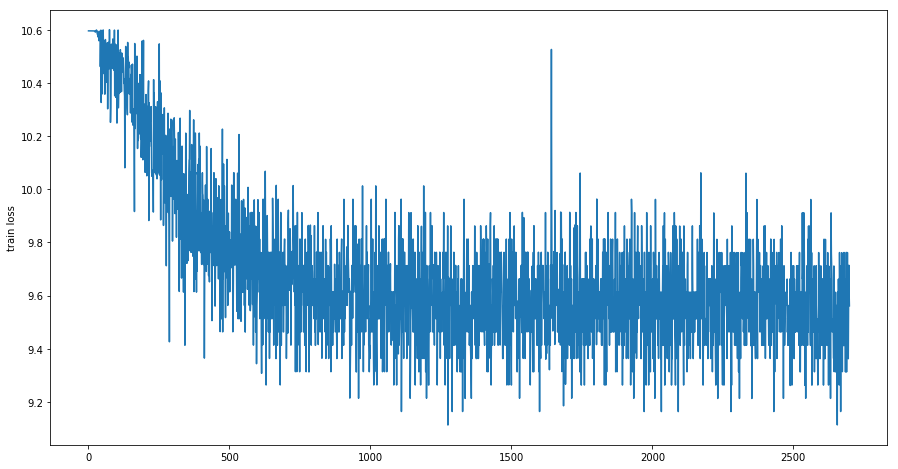

Training EM


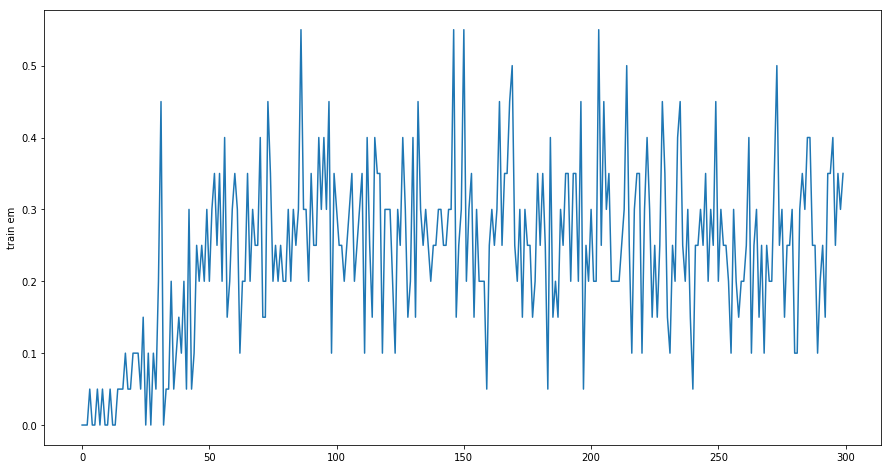

Testing EM


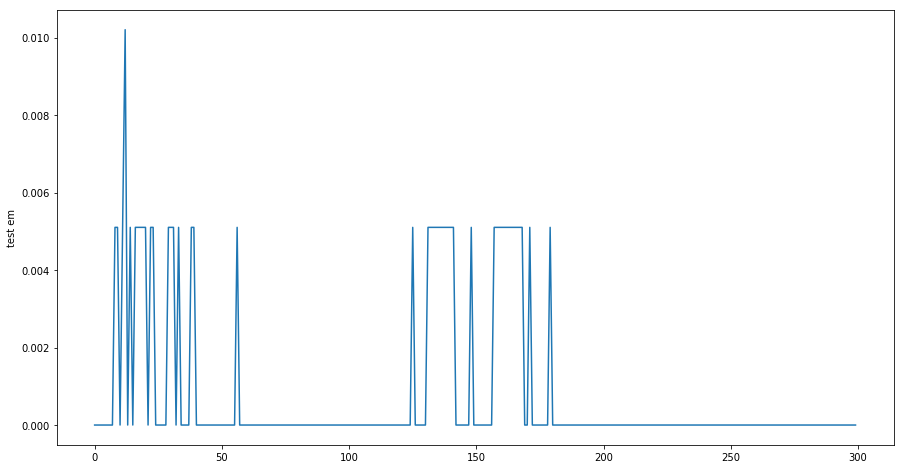

In [28]:
# Visualizations
print("Training Loss")
visualize_loss(op[0], "train loss", _only_epoch=False)

# if len(op[1]) > 0:

print("Training EM")
visualize_loss(op[1], "train em")

print("Testing EM")
visualize_loss(op[3], "test em")

